# Gender Classification CNN (VGG16, VGG-Face Transfer Learning)

In [1]:
import os
import numpy as np
from numpy import array
from numpy import argmax
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import glob
import keras
import time
from keras import backend as K
from keras.layers.core import Dense
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import np_utils
from keras.applications import imagenet_utils
from keras.optimizers import SGD
from keras.callbacks import CSVLogger, EarlyStopping, TensorBoard, ModelCheckpoint 
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import random
from scipy.misc import imread, imresize

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

%matplotlib inline



Using TensorFlow backend.


## Preprocessing

In [3]:
image_labels = pd.read_csv('train_target.csv')

In [5]:
#prepare data for flow_from_dir
from shutil import copyfile
data_size = len(image_labels.index)
train_size = data_size - (data_size * 0.2)
count = 0

for index, row in image_labels.iterrows():
    name = row['Id']
    gender = str(row['Gender']) 
    
    if count<train_size:
        
        if os.path.isdir('data/train/' + gender):
            copyfile('train/'+name, 'data/train/'+gender+'/'+name)
        else:
            os.makedirs('data/train/'+gender)
            copyfile('train/'+name, 'data/train/'+gender+'/'+name)

        count = count + 1


    else:
        if os.path.isdir('data/validation/' + gender):
            copyfile('train/'+name, 'data/validation/'+gender+'/'+name)
        else:
            os.makedirs('data/validation/'+gender)
            copyfile('train/'+name, 'data/validation/'+gender+'/'+name)
    

In [6]:
def plotImage(image):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[0].grid()
    axarr[0].set_title('Image')

In [12]:
X_train = []
Y_train = []
for index, row in image_labels.iterrows():
    image = imread('train/' + row[0], mode='RGB')
    image = imresize(image, (244,244,3))
    X_train.append(np.array(image))
    Y_train.append(row[1])

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [13]:
X_train = np.array(X_train)

In [14]:
Y_train = to_categorical(Y_train)

In [15]:
#Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=3)

49


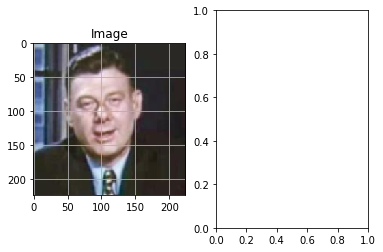

In [111]:
#Image and Ages
num = 1043
plotImage(X_train[num])
print(argmax(y_train[num]))

In [5]:
img_data = np.asarray( images )

In [16]:
num_classes = np.size(Y_train, 1)

## VGG-16 Model

In [170]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

image_input = Input(shape=(224,224,3))

model = VGG16(input_tensor=image_input, include_top = True, weights='imagenet')

for layer in model.layers:
    layer.trainable = False
    
model.summary()

AttributeError: 'InputLayer' object has no attribute 'outbound_nodes'

## VGG-Face Model

In [43]:
image_input = Input(shape=(224,224,3))
from keras_vggface.vggface import VGGFace
vgg_face_model = VGGFace(model = 'resnet50', include_top = False, weights='vggface', input_shape=((224,224,3)))
    
vgg_face_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_10[0][0]                   
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_197 (Activation)     (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [44]:
for layer in vgg_face_model.layers[:-31]:
    layer.trainable = False
    

In [45]:
LL = vgg_face_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(LL)
x = Dense(5000,name = 'fc6')(x)
x = Dropout(0.5)(x)
x = Dense(5000,name = 'fc7')(x)
x = Dropout(0.5)(x)
x = Dense(4096,name = 'fc8')(x)
x = Dropout(0.5)(x)
x = Dense(4096,name = 'fc9')(x)
out = Dense(1, activation='sigmoid',name='classifier')(x)
custom_vgg_face_model = Model(vgg_face_model.input, out)

In [46]:
custom_vgg_face_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_10[0][0]                   
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_197 (Activation)     (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [47]:
sgd = SGD(lr=1e-4, decay=1e-3, momentum=0.9)
custom_vgg_face_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 16

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(224,224),  
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='binary')  

validation_generator = test_datagen.flow_from_directory(
        'data/validation',  # this is the target directory
        target_size=(224,224),  
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='binary')


Found 22688 images belonging to 2 classes.
Found 5672 images belonging to 2 classes.


In [ ]:
# fine-tune the model

custom_vgg_face_model.fit_generator(
        train_generator,
        steps_per_epoch=22688 // batch_size,
        validation_data=validation_generator,
        validation_steps=5672  // batch_size, epochs=75)

Epoch 1/75
1418/1418 [==============================] - 333s 235ms/step - loss: 0.5061 - acc: 0.8654 - val_loss: 0.3235 - val_acc: 0.8769
Epoch 2/75
1418/1418 [==============================] - 328s 231ms/step - loss: 0.2972 - acc: 0.8985 - val_loss: 0.2905 - val_acc: 0.8826
Epoch 3/75
1417/1418 [============================>.] - ETA: 0s - loss: 0.2622 - acc: 0.9058

In [ ]:
t=time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
callback_list = [early_stop]

hist = custom_vgg_face_model.fit(X_train, y_train, batch_size=16, validation_data=(X_test, y_test), epochs=75, callbacks = callback_list, verbose=1)
#print('Training time: %s' % (t - time.time()))


In [ ]:
custom_vgg_face_model.evaluate(img_data, Y_train)

In [ ]:
from keras.models import model_from_json
model_json = custom_vgg_face_model.to_json()
with open("vgg_face_trained.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
custom_vgg_face_model.save_weights("vgg_face_model_weights.h5")
print("Saved model to disk")

In [42]:
predictions = custom_vgg_face_model.predict(testing_data)

68
[[7.95898359e-07 9.21909032e-06 2.76886851e-07 ... 4.25720458e-07
  4.23317658e-07 1.27833914e-06]
 [4.97554765e-07 8.55011706e-07 3.68742548e-08 ... 1.11947955e-07
  1.34594146e-07 2.39334611e-07]
 [1.43019060e-11 9.71408856e-11 3.89333574e-12 ... 3.09132320e-12
  1.73338405e-12 1.27860795e-11]
 ...
 [4.97396613e-08 3.89313328e-07 2.03993746e-08 ... 2.91207751e-08
  1.88591063e-08 3.22944977e-08]
 [1.96029522e-08 5.75219623e-08 7.87872345e-09 ... 2.65869655e-08
  5.56511326e-09 7.15812263e-08]
 [1.02805495e-06 1.28216993e-06 5.61833986e-07 ... 6.89571834e-07
  1.68642316e-07 6.92823562e-07]]


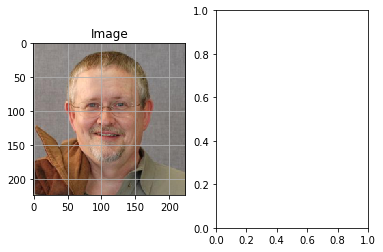

In [83]:
index = 208
print(argmax(predictions[index]))
print(predictions)
plotImage(testing_data[index])

In [64]:
from keras.models import load_model
from keras.models import model_from_json
json_file = open('vgg_face_trained.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [65]:
loaded_model.load_weights("vgg_face_model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [66]:
pred = loaded_model.predict(testing_data)

22


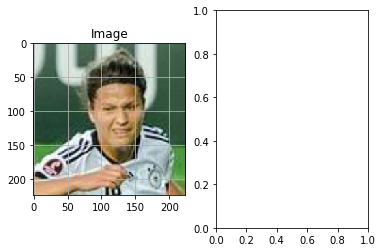

In [83]:
s = 4010
print(argmax(pred[s]))
plotImage(testing_data[s])